# Read Data Sample

In [1]:
import pandas as pd
import numpy as np
import os
from collections import namedtuple
pd.set_option("display.max_rows",100)
%matplotlib inline

In [2]:
%%bash
rm dataset/scores/tf_vae_dense_trained_together_nsl_kdd_scores-all.pkl

rm: cannot remove 'dataset/scores/tf_vae_dense_trained_together_nsl_kdd_scores-all.pkl': No such file or directory


In [3]:

class preprocess:
    
    paths = {}

    def get_files(folder_path):
        paths = {}
        for path, subdirs, files in os.walk(folder_path):
            for name in files:
                if name.endswith("csv"):
                    key = name.split("_")[0]

                    if paths.get(key) is None:
                        paths[key] = {}

                    if name.endswith("_x.csv"):
                        x = os.path.join(path, name)
                        paths[key]['x'] = x
                    elif name.endswith("_y.csv"):
                        y = os.path.join(path, name)
                        paths[key]['y'] = y
        preprocess.paths = paths
        return paths

    def get_data(paths):
        for key, value in paths.items():
            x = pd.read_csv(value['x'])
            y = pd.read_csv(value['y'])
            #print(x.shape)
            #print(x.values.shape)
            #print(y.sum())
            yield key, x.values, y.values
        
        
    
    
train_paths = preprocess.get_files("dataset/Kyoto2016/2014/01")
test_paths = preprocess.get_files("dataset/Kyoto2016/2015/12")
#test_paths.update(preprocess.get_files("dataset/Kyoto2016/2015/11"))
#test_paths.update(preprocess.get_files("dataset/Kyoto2016/2015/10"))

paths = {}
keys = train_paths.keys()
for key in list(keys)[0:7]:
    paths.update({key: train_paths[key]})
train_paths = paths
print(train_paths)
print("----------------------------------------------------------------------------------------")
#test_paths = test_paths.popitem()
#test_paths = {test_paths[0]: test_paths[1]}
print(test_paths)


{'20140115': {'x': 'dataset/Kyoto2016/2014/01/20140115_x.csv', 'y': 'dataset/Kyoto2016/2014/01/20140115_y.csv'}, '20140107': {'y': 'dataset/Kyoto2016/2014/01/20140107_y.csv', 'x': 'dataset/Kyoto2016/2014/01/20140107_x.csv'}, '20140109': {'x': 'dataset/Kyoto2016/2014/01/20140109_x.csv', 'y': 'dataset/Kyoto2016/2014/01/20140109_y.csv'}, '20140104': {'y': 'dataset/Kyoto2016/2014/01/20140104_y.csv', 'x': 'dataset/Kyoto2016/2014/01/20140104_x.csv'}, '20140119': {'x': 'dataset/Kyoto2016/2014/01/20140119_x.csv', 'y': 'dataset/Kyoto2016/2014/01/20140119_y.csv'}, '20140120': {'x': 'dataset/Kyoto2016/2014/01/20140120_x.csv', 'y': 'dataset/Kyoto2016/2014/01/20140120_y.csv'}, '20140123': {'x': 'dataset/Kyoto2016/2014/01/20140123_x.csv', 'y': 'dataset/Kyoto2016/2014/01/20140123_y.csv'}}
----------------------------------------------------------------------------------------
{'20151224': {'y': 'dataset/Kyoto2016/2015/12/20151224_y.csv', 'x': 'dataset/Kyoto2016/2015/12/20151224_x.csv'}, '20151204': {

In [4]:
import tensorflow as tf
from sklearn import model_selection as ms
from sklearn import metrics as me

In [5]:
class network(object):
    
    input_dim = 42
    classes = 2
    hidden_encoder_dim = 42
    hidden_layers = 1
    latent_dim = 10

    hidden_decoder_dim = 42
    lam = 0.001
    
    def __init__(self, classes, hidden_layers, num_of_features):
        self.classes = classes
        self.hidden_layers = hidden_layers
        self.latent_dim = num_of_features
            
    def build_layers(self):
        tf.reset_default_graph()
        #learning_rate = tf.Variable(initial_value=0.001)

        input_dim = self.input_dim
        classes = self.classes
        hidden_encoder_dim = self.hidden_encoder_dim
        hidden_layers = self.hidden_layers
        latent_dim = self.latent_dim
        hidden_decoder_dim = self.hidden_decoder_dim
        lam = self.lam
        
        with tf.variable_scope("Input"):
            self.x = tf.placeholder("float", shape=[None, input_dim])
            self.y_ = tf.placeholder("float", shape=[None, classes])
            self.keep_prob = tf.placeholder("float")
            self.lr = tf.placeholder("float")
        
        with tf.variable_scope("Layer_Encoder"):

            hidden_encoder = tf.layers.dense(self.x, hidden_encoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
            hidden_encoder = tf.nn.dropout(hidden_encoder, self.keep_prob)
            for h in range(hidden_layers - 1):
                hidden_encoder = tf.layers.dense(hidden_encoder, hidden_encoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
                hidden_encoder = tf.nn.dropout(hidden_encoder, self.keep_prob)
                
        with tf.variable_scope("Layer_Mean"):
            mu_encoder = tf.layers.dense(hidden_encoder, latent_dim, activation = None, kernel_regularizer=tf.nn.l2_loss)

        with tf.variable_scope("Layer_Variance"):
            logvar_encoder = tf.layers.dense(hidden_encoder, latent_dim, activation = None, kernel_regularizer=tf.nn.l2_loss)

        with tf.variable_scope("Sampling_Distribution"):
            # Sample epsilon
            epsilon = tf.random_normal(tf.shape(logvar_encoder), mean=0, stddev=1, name='epsilon')

            # Sample latent variable
            std_encoder = tf.exp(0.5 * logvar_encoder)
            z = mu_encoder + tf.multiply(std_encoder, epsilon)
            
            #tf.summary.histogram("Sample_Distribution", z)

        with tf.variable_scope("Layer_Decoder"):
            hidden_decoder = tf.layers.dense(z, hidden_decoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
            hidden_decoder = tf.nn.dropout(hidden_decoder, self.keep_prob)
            for h in range(hidden_layers - 1):
                hidden_decoder = tf.layers.dense(hidden_decoder, hidden_decoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
                hidden_decoder = tf.nn.dropout(hidden_decoder, self.keep_prob)
                
        with tf.variable_scope("Layer_Reconstruction"):
            x_hat = tf.layers.dense(hidden_decoder, input_dim, activation = None)
            
        with tf.variable_scope("Layer_Dense_Hidden"):
            hidden_output = tf.layers.dense(z,latent_dim, activation=tf.nn.relu)

        with tf.variable_scope("Layer_Dense_Softmax"):
            self.y = tf.layers.dense(z, classes, activation=tf.nn.softmax)

        with tf.variable_scope("Loss"):
            
            BCE = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=x_hat, labels=self.x), reduction_indices=1)
            KLD = -0.5 * tf.reduce_mean(1 + logvar_encoder - tf.pow(mu_encoder, 2) - tf.exp(logvar_encoder), reduction_indices=1)
            softmax_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = self.y_, logits = self.y))

            loss = tf.reduce_mean((BCE + KLD + softmax_loss) * lam)

            loss = tf.clip_by_value(loss, -1e-2, 1e-2)
            loss = tf.where(tf.is_nan(loss), 1e-2, loss)
            loss = tf.where(tf.equal(loss, -1e-2), tf.random_normal(loss.shape), loss)
            loss = tf.where(tf.equal(loss, 1e-2), tf.random_normal(loss.shape), loss)
            
            self.regularized_loss = tf.abs(loss, name = "Regularized_loss")
            correct_prediction = tf.equal(tf.argmax(self.y_, 1), tf.argmax(self.y, 1))
            self.tf_accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name = "Accuracy")

        with tf.variable_scope("Optimizer"):
            learning_rate=self.lr #1e-2
            optimizer = tf.train.AdamOptimizer(learning_rate)
            gradients, variables = zip(*optimizer.compute_gradients(self.regularized_loss))
            gradients = [
                None if gradient is None else tf.clip_by_value(gradient, -1, 1)
                for gradient in gradients]
            self.train_op = optimizer.apply_gradients(zip(gradients, variables))
            #self.train_op = optimizer.minimize(self.regularized_loss)
            
        # add op for merging summary
        #self.summary_op = tf.summary.merge_all()
        self.pred = tf.argmax(self.y, axis = 1)
        self.actual = tf.argmax(self.y_, axis = 1)

        # add Saver ops
        self.saver = tf.train.Saver()
        

In [6]:
import collections
import time

class Train:    
    
    result = namedtuple("score", ['key', 'no_of_features','hidden_layers','train_score', 'test_score', 'f1_score', 'time_taken'])

    predictions = {}

    results = []
    best_acc = 0
    best_acc_global = 0

    def train(epochs, net, h,f, lrs):
        batch_iterations = 1000
        train_loss = None
        Train.best_acc = 0
        os.makedirs("dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_{}_features count_{}".format(h,f),
                    exist_ok = True)

        with tf.Session() as sess:
            #summary_writer_train = tf.summary.FileWriter('./logs/kdd/VAE/training', graph=sess.graph)
            #summary_writer_valid = tf.summary.FileWriter('./logs/kdd/VAE/validation')

            sess.run(tf.global_variables_initializer())
            start_time = time.perf_counter()

            Train.best_acc = 0
            for lr in lrs:
                for epoch in range(1, (epochs+1)):
                    
                    for key, x_train, y_train in preprocess.get_data(train_paths):
                        x_train, x_valid, y_train, y_valid, = ms.train_test_split(x_train, 
                                                                                  y_train, 
                                                                                  test_size=0.1)
                    
                        batch_indices = np.array_split(np.arange(x_train.shape[0]), 
                                                   batch_iterations)

                        for i in batch_indices:

                            def train_batch():
                                nonlocal train_loss
                                _, train_loss = sess.run([net.train_op, 
                                                                       net.regularized_loss, 
                                                                       ], #net.summary_op
                                                                      feed_dict={net.x: x_train[i,:], 
                                                                                 net.y_: y_train[i,:], 
                                                                                 net.keep_prob:1, net.lr:lr})

                            train_batch()
                            count = 10

                            while((train_loss > 1e9 or np.isnan(train_loss)) and epoch > 1 and count > 1):
                                print("Step {} | High Training Loss: {:.6f} ... Restoring Net".format(epoch, train_loss))
                                net.saver.restore(sess, 
                                                  tf.train.latest_checkpoint('dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_{}_features count_{}'
                                                                             .format(h,f)))
                                train_batch()
                                count -= 1

                        valid_loss, valid_accuracy = sess.run([net.regularized_loss, net.tf_accuracy], #net.summary_op
                                                                  feed_dict={net.x: x_valid, 
                                                                             net.y_: y_valid, 
                                                                             net.keep_prob:1, net.lr:lr})
                        
                    end_time = time.perf_counter()    
                    for key, x_test, y_test in preprocess.get_data(test_paths):
                        test_accuracy, test_loss, pred_value, actual_value, y_pred = sess.run([net.tf_accuracy, net.regularized_loss, net.pred, 
                                                                                          net.actual, net.y], #net.summary_op 
                                                                                          feed_dict={net.x: x_test, 
                                                                                         net.y_: y_test, 
                                                                                         net.keep_prob:1, net.lr:lr})

                        
                        f1_score = me.f1_score(actual_value, pred_value)
                        recall = me.recall_score(actual_value, pred_value)
                        prec = me.precision_score(actual_value, pred_value)
                        print("Key {} | Training Loss: {:.6f} | Train Accuracy: {:.6f} | Test Accuracy: {:.6f}, f1_score: {}, recall: {}, prec: {}".format(key, train_loss, valid_accuracy, test_accuracy, f1_score, recall, prec))

                        if test_accuracy > Train.best_acc_global:
                            Train.best_acc_global = test_accuracy
                            Train.pred_value = pred_value
                            Train.actual_value = actual_value

                            Train.best_parameters = "Hidden Layers:{}, Features Count:{}".format(h, f)

                        curr_pred = pd.DataFrame({"Attack_prob":y_pred[:,-2], "Normal_prob":y_pred[:, -1], "Prediction":pred_value, "Actual":actual_value})
                        Train.predictions.update({"{}_{}_{}".format(key,f,h):
                                                  (curr_pred, 
                                                   Train.result(key, f, h,valid_accuracy, test_accuracy, f1_score, end_time - start_time))})
                        #Train.results.append(Train.result(epochs, f, h,valid_accuracy, test_accuracy))
                print("Best Accuracy on Test data: {}".format(Train.best_acc))


In [7]:
import itertools

df_results = []
past_scores = []

class Hyperparameters:
#    features_arr = [2, 4, 8, 16, 32, 64, 128, 256]
#    hidden_layers_arr = [2, 4, 6, 10]

    def start_training():
        global df_results
        global past_scores
        
        features_arr = [1, 4, 8, 16, 42]
        hidden_layers_arr = [1, 3]

        Train.predictions = {}
        Train.results = []

        epochs = [1]
        lrs = [1e-4]

        for e, h, f in itertools.product(epochs, hidden_layers_arr, features_arr):
            print("Current Layer Attributes - epochs:{} hidden layers:{} features count:{}".format(e,h,f))
            n = network(2,h,f)
            n.build_layers()
            Train.train(e, n, h,f, lrs)

        dict1 = {}
        dict2 = []
        for k, (v1, v2) in Train.predictions.items():
            dict1.update({k: v1})
            dict2.append(v2)
            
        Train.predictions = dict1
        Train.results = dict2
        df_results = pd.DataFrame(Train.results)
        #temp = df_results.set_index(['no_of_features', 'hidden_layers'])

        if not os.path.isfile('dataset/scores/tf_vae_dense_trained_together_nsl_kdd_scores-all.pkl'):
            past_scores = df_results
        else:
            past_scores = pd.read_pickle("dataset/scores/tf_vae_dense_trained_together_nsl_kdd_scores-all.pkl")

        past_scores.append(df_results).to_pickle("dataset/scores/tf_vae_dense_trained_together_nsl_kdd_scores-all.pkl")


In [8]:
#%%timeit -r 1

Hyperparameters.start_training()

Current Layer Attributes - epochs:1 hidden layers:1 features count:1
Key 20151224 | Training Loss: 0.000019 | Train Accuracy: 0.995310 | Test Accuracy: 0.982835, f1_score: 0.9913428743554591, recall: 0.9999186606762647, prec: 0.9829129373474369
Key 20151204 | Training Loss: 0.000019 | Train Accuracy: 0.995310 | Test Accuracy: 0.986732, f1_score: 0.9933217853994942, recall: 0.999960080274938, prec: 0.9867710467131745
Key 20151216 | Training Loss: 0.000019 | Train Accuracy: 0.995310 | Test Accuracy: 0.978833, f1_score: 0.9893033783589055, recall: 0.9999955182474555, prec: 0.9788374643562184
Key 20151222 | Training Loss: 0.000019 | Train Accuracy: 0.995310 | Test Accuracy: 0.986753, f1_score: 0.9933320122130233, recall: 0.9999852225666185, prec: 0.9867667484479182
Key 20151214 | Training Loss: 0.000019 | Train Accuracy: 0.995310 | Test Accuracy: 0.984951, f1_score: 0.9924185020542869, recall: 0.9999745500663819, prec: 0.9849757882906408
Key 20151202 | Training Loss: 0.000019 | Train Accur

Key 20151210 | Training Loss: 0.000009 | Train Accuracy: 0.923411 | Test Accuracy: 0.904207, f1_score: 0.9495637767170264, recall: 0.9139090706572504, prec: 0.9881134483254034
Key 20151217 | Training Loss: 0.000009 | Train Accuracy: 0.923411 | Test Accuracy: 0.886127, f1_score: 0.9391244732119453, recall: 0.9089087656529516, prec: 0.9714182419889733
Key 20151207 | Training Loss: 0.000009 | Train Accuracy: 0.923411 | Test Accuracy: 0.915807, f1_score: 0.9557555697288262, recall: 0.9431031489398641, prec: 0.9687520898816291
Key 20151215 | Training Loss: 0.000009 | Train Accuracy: 0.923411 | Test Accuracy: 0.903924, f1_score: 0.9492685054376168, recall: 0.9164558259767935, prec: 0.9845180779760219
Key 20151213 | Training Loss: 0.000009 | Train Accuracy: 0.923411 | Test Accuracy: 0.850316, f1_score: 0.919007572882456, recall: 0.8572793915284346, prec: 0.9903149449272681
Key 20151209 | Training Loss: 0.000009 | Train Accuracy: 0.923411 | Test Accuracy: 0.902758, f1_score: 0.9487428519358947

/home/ritesh_malaiya/anaconda3/envs/p3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ritesh_malaiya/anaconda3/envs/p3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Key 20151224 | Training Loss: 1.882938 | Train Accuracy: 0.003552 | Test Accuracy: 0.017113, f1_score: 0.0, recall: 0.0, prec: 0.0
Key 20151204 | Training Loss: 1.882938 | Train Accuracy: 0.003552 | Test Accuracy: 0.013250, f1_score: 0.0, recall: 0.0, prec: 0.0
Key 20151216 | Training Loss: 1.882938 | Train Accuracy: 0.003552 | Test Accuracy: 0.021162, f1_score: 0.0, recall: 0.0, prec: 0.0
Key 20151222 | Training Loss: 1.882938 | Train Accuracy: 0.003552 | Test Accuracy: 0.013258, f1_score: 0.0, recall: 0.0, prec: 0.0
Key 20151214 | Training Loss: 1.882938 | Train Accuracy: 0.003552 | Test Accuracy: 0.015028, f1_score: 0.0, recall: 0.0, prec: 0.0
Key 20151202 | Training Loss: 1.882938 | Train Accuracy: 0.003552 | Test Accuracy: 0.046480, f1_score: 0.0, recall: 0.0, prec: 0.0
Key 20151227 | Training Loss: 1.882938 | Train Accuracy: 0.003552 | Test Accuracy: 0.011803, f1_score: 0.0, recall: 0.0, prec: 0.0
Key 20151203 | Training Loss: 1.882938 | Train Accuracy: 0.003552 | Test Accuracy: 

Key 20151224 | Training Loss: 1.076506 | Train Accuracy: 0.003759 | Test Accuracy: 0.017113, f1_score: 0.0, recall: 0.0, prec: 0.0
Key 20151204 | Training Loss: 1.076506 | Train Accuracy: 0.003759 | Test Accuracy: 0.013250, f1_score: 0.0, recall: 0.0, prec: 0.0
Key 20151216 | Training Loss: 1.076506 | Train Accuracy: 0.003759 | Test Accuracy: 0.021162, f1_score: 0.0, recall: 0.0, prec: 0.0
Key 20151222 | Training Loss: 1.076506 | Train Accuracy: 0.003759 | Test Accuracy: 0.013258, f1_score: 0.0, recall: 0.0, prec: 0.0
Key 20151214 | Training Loss: 1.076506 | Train Accuracy: 0.003759 | Test Accuracy: 0.015028, f1_score: 0.0, recall: 0.0, prec: 0.0
Key 20151202 | Training Loss: 1.076506 | Train Accuracy: 0.003759 | Test Accuracy: 0.046480, f1_score: 0.0, recall: 0.0, prec: 0.0
Key 20151227 | Training Loss: 1.076506 | Train Accuracy: 0.003759 | Test Accuracy: 0.011803, f1_score: 0.0, recall: 0.0, prec: 0.0
Key 20151203 | Training Loss: 1.076506 | Train Accuracy: 0.003759 | Test Accuracy: 

Key 20151218 | Training Loss: 0.000050 | Train Accuracy: 0.734887 | Test Accuracy: 0.813921, f1_score: 0.8965633209386143, recall: 0.8238851051919578, prec: 0.9833045681040002
Key 20151231 | Training Loss: 0.000050 | Train Accuracy: 0.734887 | Test Accuracy: 0.718285, f1_score: 0.8312390610372317, recall: 0.7497403909694518, prec: 0.9326168647031193
Key 20151212 | Training Loss: 0.000050 | Train Accuracy: 0.734887 | Test Accuracy: 0.739998, f1_score: 0.8494890085393876, recall: 0.7500880065105892, prec: 0.9792596326330927
Key 20151211 | Training Loss: 0.000050 | Train Accuracy: 0.734887 | Test Accuracy: 0.758971, f1_score: 0.8625887465575178, recall: 0.7641776345241292, prec: 0.9900933820544052
Key 20151221 | Training Loss: 0.000050 | Train Accuracy: 0.734887 | Test Accuracy: 0.811662, f1_score: 0.8956815262109463, recall: 0.8194271955995223, prec: 0.987584229390681
Key 20151201 | Training Loss: 0.000050 | Train Accuracy: 0.734887 | Test Accuracy: 0.792123, f1_score: 0.8827024636436953

Key 20151203 | Training Loss: 0.000105 | Train Accuracy: 0.948895 | Test Accuracy: 0.887800, f1_score: 0.9391619494834876, recall: 0.9556021434365014, prec: 0.9232778629484665
Key 20151223 | Training Loss: 0.000105 | Train Accuracy: 0.948895 | Test Accuracy: 0.925542, f1_score: 0.961160543979214, recall: 0.9545126427719386, prec: 0.9679016960239218
Key 20151205 | Training Loss: 0.000105 | Train Accuracy: 0.948895 | Test Accuracy: 0.923272, f1_score: 0.9600325653467076, recall: 0.934113031293788, prec: 0.9874315688024836
Key 20151229 | Training Loss: 0.000105 | Train Accuracy: 0.948895 | Test Accuracy: 0.903300, f1_score: 0.9489995327306125, recall: 0.924873523208307, prec: 0.9744179451219275
Key 20151208 | Training Loss: 0.000105 | Train Accuracy: 0.948895 | Test Accuracy: 0.944766, f1_score: 0.9715424275945944, recall: 0.9588023111054362, prec: 0.9846256728316953
Key 20151219 | Training Loss: 0.000105 | Train Accuracy: 0.948895 | Test Accuracy: 0.728877, f1_score: 0.8311634055752359, 

Key 20151218 | Training Loss: 0.000024 | Train Accuracy: 0.973275 | Test Accuracy: 0.949693, f1_score: 0.9741310996190398, recall: 0.9676727153986099, prec: 0.980676271406791
Key 20151231 | Training Loss: 0.000024 | Train Accuracy: 0.973275 | Test Accuracy: 0.896909, f1_score: 0.9451566706370791, recall: 0.9599450363103001, prec: 0.9308170343473795
Key 20151212 | Training Loss: 0.000024 | Train Accuracy: 0.973275 | Test Accuracy: 0.914224, f1_score: 0.9550618031145977, recall: 0.9318129341181369, prec: 0.9795004834416269
Key 20151211 | Training Loss: 0.000024 | Train Accuracy: 0.973275 | Test Accuracy: 0.929753, f1_score: 0.9635605689063267, recall: 0.9381681439699168, prec: 0.9903657729750165
Key 20151221 | Training Loss: 0.000024 | Train Accuracy: 0.973275 | Test Accuracy: 0.941227, f1_score: 0.9696894855106152, recall: 0.952788127084731, prec: 0.9872012936750924
Key 20151201 | Training Loss: 0.000024 | Train Accuracy: 0.973275 | Test Accuracy: 0.944527, f1_score: 0.9714001835028119,

In [9]:
pd.Panel(Train.predictions).to_pickle("dataset/tf_vae_dense_trained_together_nsl_kdd_predictions.pkl")
df_results.to_pickle("dataset/tf_vae_dense_trained_together_nsl_kdd_scores.pkl")

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=4)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        #print('Confusion matrix, without normalization')
        pass
    
    #print(cm)

    label = [["\n True Positive", "\n False Negative \n Type II Error"],
             ["\n False Positive \n Type I Error", "\n True Negative"]
            ]
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        
        plt.text(j, i, "{} {}".format(cm[i, j].round(4), label[i][j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot(actual_value, pred_value):
    from sklearn.metrics import confusion_matrix

    cm_2labels = confusion_matrix(y_pred = pred_value, y_true = actual_value)
    plt.figure(figsize=[6,6])
    plot_confusion_matrix(cm_2labels, ['Normal', 'Attack'], normalize = False)


In [11]:
past_scores = pd.read_pickle("dataset/scores/tf_vae_dense_trained_together_nsl_kdd_scores-all.pkl")

In [12]:
past_scores

,key,no_of_features,hidden_layers,train_score,test_score,f1_score,time_taken
0,20151224,1,1,0.995310,0.982835,0.991343,30.252922
1,20151204,1,1,0.995310,0.986732,0.993322,30.252922
2,20151216,1,1,0.995310,0.978833,0.989303,30.252922
3,20151222,1,1,0.995310,0.986753,0.993332,30.252922
4,20151214,1,1,0.995310,0.984951,0.992419,30.252922
5,20151202,1,1,0.995310,0.953475,0.976183,30.252922
6,20151227,1,1,0.995310,0.988185,0.994057,30.252922
7,20151203,1,1,0.995310,0.906209,0.950797,30.252922
8,20151223,1,1,0.995310,0.965192,0.982288,30.252922
9,20151205,1,1,0.995310,0.986490,0.993199,30.252922


In [13]:
past_scores.sort_values(by='f1_score', ascending = False)

,key,no_of_features,hidden_layers,train_score,test_score,f1_score,time_taken
19,20151213,1,1,0.995310,0.990592,0.995274,30.252922
19,20151213,1,1,0.995310,0.990592,0.995274,30.252922
26,20151211,1,1,0.995310,0.989958,0.994953,30.252922
26,20151211,1,1,0.995310,0.989958,0.994953,30.252922
21,20151228,1,1,0.995310,0.988677,0.994306,30.252922
21,20151228,1,1,0.995310,0.988677,0.994306,30.252922
6,20151227,1,1,0.995310,0.988185,0.994057,30.252922
6,20151227,1,1,0.995310,0.988185,0.994057,30.252922
3,20151222,1,1,0.995310,0.986753,0.993332,30.252922
3,20151222,1,1,0.995310,0.986753,0.993332,30.252922


In [14]:
psg = past_scores.sort_values(by='f1_score', ascending=False).groupby(by=['no_of_features', 'hidden_layers'])
psg.first().sort_values(by='f1_score', ascending=False)

key  train_score  test_score  f1_score  \
no_of_features hidden_layers                                                
1              1              20151213     0.995310    0.990592  0.995274   
42             3              20151225     0.986448    0.976603  0.988157   
16             3              20151225     0.973275    0.958501  0.978784   
8              3              20151225     0.948895    0.948525  0.973538   
4              1              20151225     0.923411    0.934409  0.965990   
               3              20151208     0.864168    0.895378  0.944515   
1              3              20151206     0.734887    0.822127  0.901842   
8              1              20151223     0.003552    0.034788  0.000000   
16             1              20151224     0.003414    0.017113  0.000000   
42             1              20151230     0.003759    0.051090  0.000000   

                              time_taken  
no_of_features hidden_layers              
1              1               30.252922  
42             3               44.915621  
16             3               42.956834  
8              3               43.224703  
4              1               32.132440  
               3               42.929413  
1              3               41.549513  
8              1               32.908966  
16             1               33.042446  
42             1               33.607306

In [15]:
#key_nof_hidden '20151201_16_1'
Train.predictions = pd.read_pickle("dataset/tf_vae_dense_trained_together_nsl_kdd_predictions.pkl")

In [21]:
df = Train.predictions['20151228_1_1'].dropna()

In [22]:
#Train.predictions['20151219_42_1'].loc[:,'Prediction']
df.loc[:,'Prediction'].values.astype(int)

array([1, 1, 1, ..., 1, 1, 1])

In [23]:
from sklearn import metrics as me
me.f1_score(df.loc[:,'Actual'].values.astype(int),
            df.loc[:,'Prediction'].values.astype(int) )

0.99430638281572759

In [24]:
df.groupby(by="Actual").Actual.count()

Actual
0.0      4159
1.0    363423
Name: Actual, dtype: int64

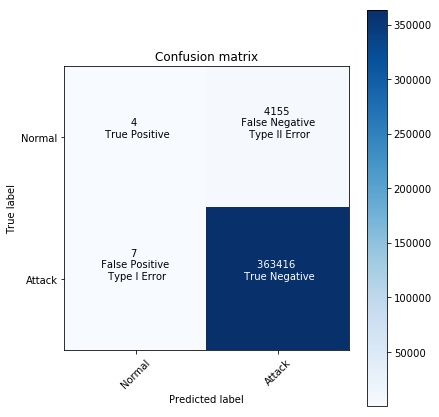

In [25]:
plot(actual_value = df.loc[:,'Actual'].values.astype(int),
     pred_value = df.loc[:,'Prediction'].values.astype(int))

In [26]:
psg.mean().sort_values(by='f1_score', ascending=False)

train_score  test_score  f1_score  time_taken
no_of_features hidden_layers                                               
1              1                 0.995310    0.961721  0.979581   30.252922
42             3                 0.986448    0.947723  0.972223   44.915621
16             3                 0.973275    0.923643  0.959251   42.956834
8              3                 0.948895    0.906955  0.950026   43.224703
4              1                 0.923411    0.892685  0.942055   32.132440
               3                 0.864168    0.849429  0.916680   42.929413
1              3                 0.734887    0.779953  0.873645   41.549513
8              1                 0.003552    0.038258  0.000000   32.908966
16             1                 0.003414    0.038258  0.000000   33.042446
42             1                 0.003759    0.038258  0.000000   33.607306

In [27]:
psg.std()

train_score  test_score  f1_score  time_taken
no_of_features hidden_layers                                               
1              1                      0.0    0.055454  0.032589         0.0
               3                      0.0    0.028077  0.020820         0.0
4              1                      0.0    0.039070  0.024784         0.0
               3                      0.0    0.031096  0.021098         0.0
8              1                      0.0    0.055450  0.000000         0.0
               3                      0.0    0.042118  0.026527         0.0
16             1                      0.0    0.055450  0.000000         0.0
               3                      0.0    0.045102  0.028088         0.0
42             1                      0.0    0.055450  0.000000         0.0
               3                      0.0    0.051008  0.030530         0.0

In [28]:
from scipy import stats

def fn(x):
    #print(x)
    return stats.norm.interval(0.95, loc=x.f1_score.mean(), scale=x.f1_score.std())
psg.apply(fn)

/home/ritesh_malaiya/anaconda3/envs/p3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1907: RuntimeWarning: invalid value encountered in multiply
  lower_bound = self.a * scale + loc
/home/ritesh_malaiya/anaconda3/envs/p3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1908: RuntimeWarning: invalid value encountered in multiply
  upper_bound = self.b * scale + loc


no_of_features  hidden_layers
1               1                 (0.915707847046, 1.04345506437)
                3                (0.832838076876, 0.914452600852)
4               1                (0.893479728224, 0.990629680824)
                3                (0.875329482057, 0.958031449982)
8               1                                      (nan, nan)
                3                 (0.898033640418, 1.00201797666)
16              1                                      (nan, nan)
                3                 (0.904199217357, 1.01430179057)
42              1                                      (nan, nan)
                3                  (0.91238564696, 1.03205998597)
dtype: object